In [16]:
import pandas as pd

# Wczytaj dane z pliku Excel
df = pd.read_excel("oczyszczone_dane_lotniska.xlsx")

# Sprawdź kolumny
print(df.columns)

# Wyciągnij unikalne wartości z kolumny 'lotnisko'
lotniska = df["lotnisko"].dropna().unique()

# Wyświetl unikalne lotniska
print("Unikalne lotniska:")
for l in lotniska:
    print("-", l)

Index(['kraj', 'lotnisko', 'rok', 'pax', 'lotniska_300km', 'flota_komercyjna',
       'pasy_startowe', 'bramki', 'odprawy', 'autostrady_km',
       'kolej_elektr_km', 'ofiary_lotnicze', 'turystyka', 'dostep_morze_kraj',
       'dostep_morze_miasto', 'lotniska_kraj', 'pkb_pps', 'pkb_realny',
       'powierzchnia_km2'],
      dtype='object')
Unikalne lotniska:
- PARIS-CHARLES DE  GAULLE airport
- AMSTERDAM/SCHIPHOL airport
- ADOLFO SUÁREZ MADRID-BARAJAS airport
- FRANFKURT/MAIN airport
- BARCELONA/EL PRAT airport
- ROMA/FIUMICINO airport
- MUENCHEN airport
- LISBOA airport
- DUBLIN airport
- PARIS-ORLY airport


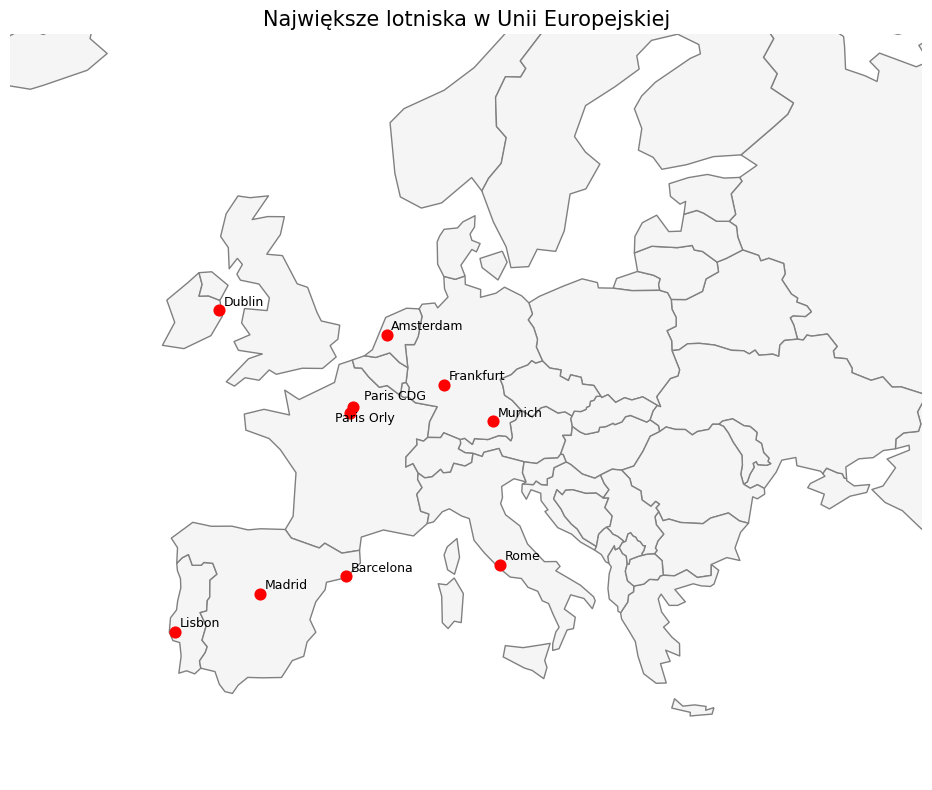

In [30]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import pandas as pd

# 1. Przygotowanie nazw lotnisk
lotniska = df["lotnisko"].dropna().unique()
lotniska = [l.replace("FRANFKURT", "FRANKFURT") for l in lotniska]

# 2. Geokodowanie
geolocator = Nominatim(user_agent="airport_mapper")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

locations = []
for name in lotniska:
    loc = geocode(name)
    if loc:
        locations.append({
            "lotnisko": name,
            "lat": loc.latitude,
            "lon": loc.longitude
        })

df_geo = pd.DataFrame(locations)

# 3. Normalizacja nazw i przypisanie skrótów
df_geo["lotnisko_norm"] = df_geo["lotnisko"].str.replace(r"\s+", " ", regex=True).str.strip()

etykiety = {
    'PARIS-CHARLES DE GAULLE airport': 'Paris CDG',
    'PARIS-ORLY airport': 'Paris Orly',
    'AMSTERDAM/SCHIPHOL airport': 'Amsterdam',
    'ADOLFO SUÁREZ MADRID-BARAJAS airport': 'Madrid',
    'FRANKFURT/MAIN airport': 'Frankfurt',
    'BARCELONA/EL PRAT airport': 'Barcelona',
    'ROMA/FIUMICINO airport': 'Rome',
    'MUENCHEN airport': 'Munich',
    'LISBOA airport': 'Lisbon',
    'DUBLIN airport': 'Dublin'
}

df_geo["etykieta"] = df_geo["lotnisko_norm"].map(etykiety)

# 4. Tworzenie GeoDataFrame
gdf = gpd.GeoDataFrame(df_geo, geometry=gpd.points_from_xy(df_geo.lon, df_geo.lat), crs="EPSG:4326")

# 5. Wczytanie mapy Europy
shp_path = r"C:\Users\abudzyns\OneDrive - uek.krakow.pl\Badania\2025 transport problems\ne_110m_admin_0_countries.shp"
world = gpd.read_file(shp_path)
europa = world[world["CONTINENT"] == "Europe"]

# 6. Rysowanie mapy
fig, ax = plt.subplots(figsize=(12, 8))
europa.plot(ax=ax, color="whitesmoke", edgecolor="gray")
gdf.plot(ax=ax, color="red", markersize=60)

# 7. Etykiety (z uwzględnieniem Paryża)
for idx, row in gdf.iterrows():
    label = row["etykieta"]
    if pd.notna(label):
        if label == "Paris CDG":
            ax.text(row.lon + 0.7, row.lat + 0.3, label, fontsize=9)
        elif label == "Paris Orly":
            ax.text(row.lon - 1.0, row.lat - 0.4, label, fontsize=9)
        else:
            ax.text(row.lon + 0.3, row.lat + 0.2, label, fontsize=9)

# 8. Zakres Europy + opis
ax.set_xlim(-20, 40)
ax.set_ylim(32, 66)
ax.set_title("Największe lotniska w Unii Europejskiej", fontsize=15)
ax.axis("off")
plt.tight_layout()
plt.show()